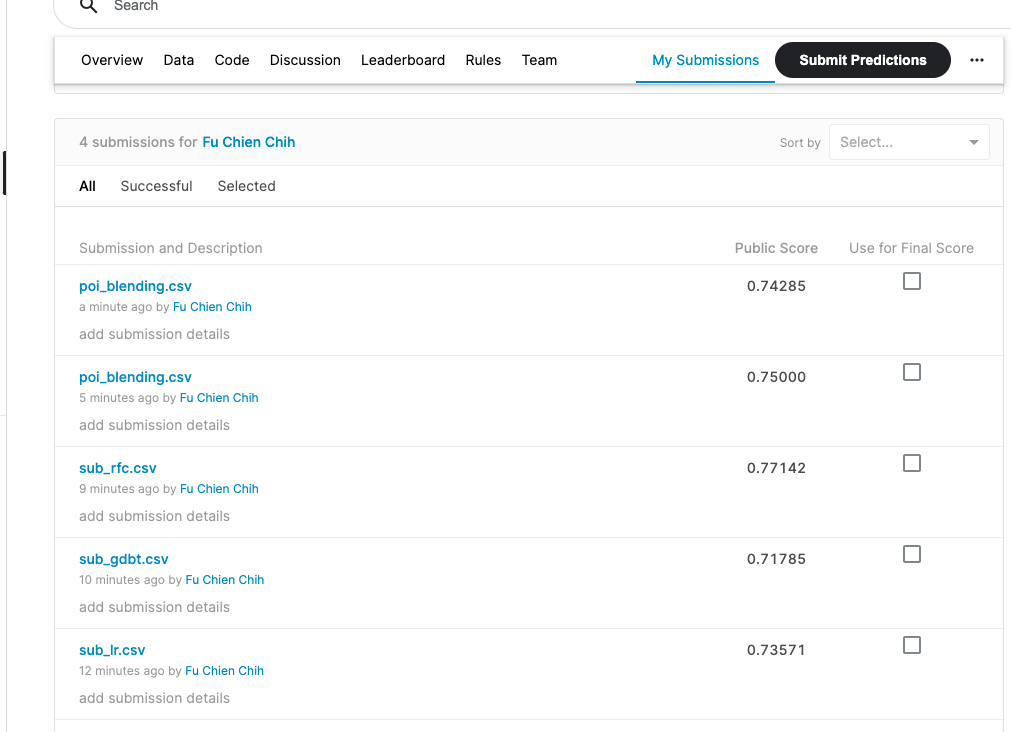

In [1]:
import pandas as pd 
import numpy as np 
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [41]:
train_data = pd.read_csv('train_data.csv')
test_features = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [42]:
# 訓練用資料
train_data.shape 

(113, 22)

In [43]:
# 測試用資料
test_features.shape

(33, 21)

In [44]:
# 答案範例
sample_submission.head()

,name,poi
0,BELDEN TIMOTHY N,0.007201
1,BOWEN JR RAYMOND M,0.903340
2,HANNON KEVIN P,0.572731
3,DELAINEY DAVID W,0.950927
4,CAUSEY RICHARD A,0.942402


In [6]:
# feature 
pd.DataFrame(test_features.columns , columns = ['Feature'])

,Feature
0,name
1,bonus
2,deferral_payments
3,deferred_income
4,director_fees
5,email_address
6,exercised_stock_options
7,expenses
8,from_messages
9,from_poi_to_this_person


In [48]:
ids = test_features.name
y_train = train_data['poi']
df_train = train_data.drop(['poi'] , axis = 1)
df_test = test_features
df = pd.concat([df_train,df_test] , ignore_index = True)
df = df.drop(['name'] , axis = 1)
df.shape # 所有資料

(146, 20)

In [49]:
y_train = y_train.apply(lambda x : int(x)) # True --> 1 , False --> 0

In [50]:
# 個特徵空值所佔比率
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)
na_check(df)

,Missing Ratio
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_messages,41.095890
from_poi_to_this_person,41.095890
from_this_person_to_poi,41.095890


In [51]:
# 將8成以上資料為空值的特徵刪除
few_data_feature = ['loan_advances','director_fees','restricted_stock_deferred']
df = df.drop(few_data_feature , axis = 1)
# 將缺失值補0
df = df.fillna(0)
df['email_address'][df['email_address'] != 0] = 1  # email_address = 1 --> 有資料， 0 --> 沒資料

In [52]:
# email 紀錄
mail_feature = ['from_messages' , 'to_messages' , 'from_poi_to_this_person'
                , 'from_this_person_to_poi' ,'shared_receipt_with_poi','email_address']

In [53]:
# finanace_features 金融特徵資料
finanace_features = list(df.columns)
for i in mail_feature:
    finanace_features.remove(i)
finanace_features

['bonus',
 'deferral_payments',
 'deferred_income',
 'exercised_stock_options',
 'expenses',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'salary',
 'total_payments',
 'total_stock_value']

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bonus                    146 non-null    float64
 1   deferral_payments        146 non-null    float64
 2   deferred_income          146 non-null    float64
 3   email_address            146 non-null    object 
 4   exercised_stock_options  146 non-null    float64
 5   expenses                 146 non-null    float64
 6   from_messages            146 non-null    float64
 7   from_poi_to_this_person  146 non-null    float64
 8   from_this_person_to_poi  146 non-null    float64
 9   long_term_incentive      146 non-null    float64
 10  other                    146 non-null    float64
 11  restricted_stock         146 non-null    float64
 12  salary                   146 non-null    float64
 13  shared_receipt_with_poi  146 non-null    float64
 14  to_messages              1

bonus


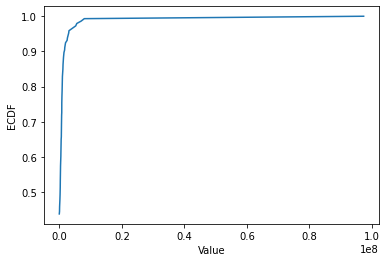

deferral_payments


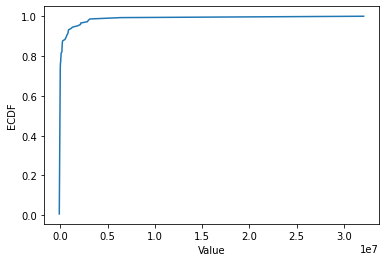

deferred_income


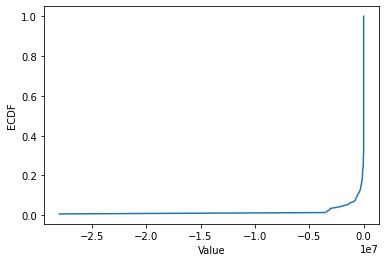

exercised_stock_options


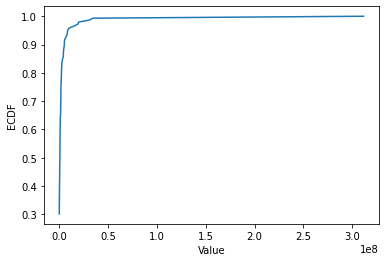

expenses


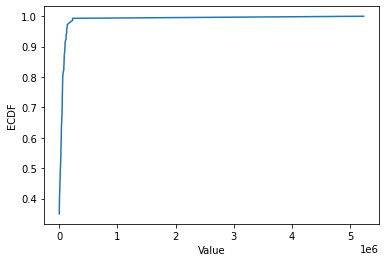

long_term_incentive


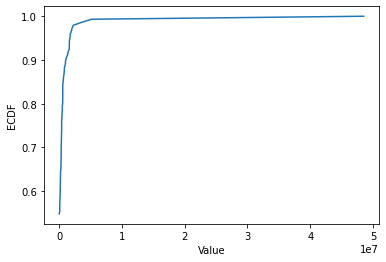

other


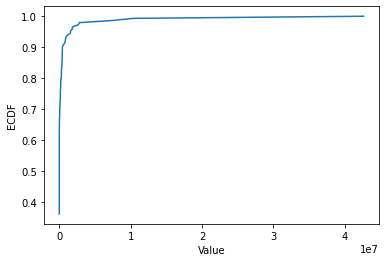

restricted_stock


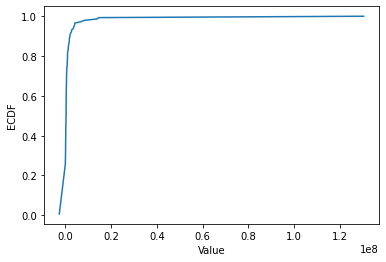

salary


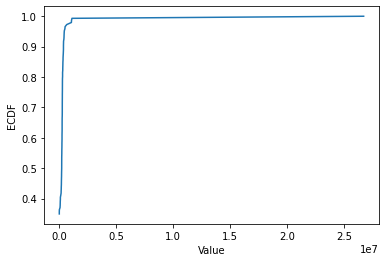

total_payments


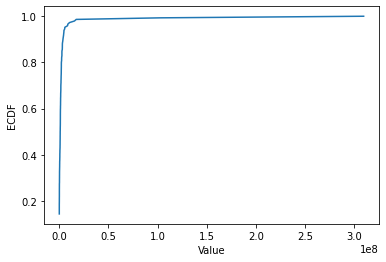

total_stock_value


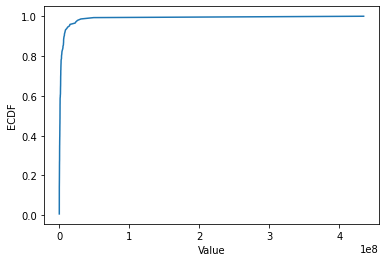

In [55]:
# 離群值 利用ECDF(Emprical Cumulative Density Plot)
for col in finanace_features:
    
    cdf = df[col].value_counts().sort_index().cumsum()
    plt.plot(list(cdf.index), cdf/cdf.max())
    plt.xlabel('Value')
    plt.ylabel('ECDF')
    print(col)
    plt.show()
   
# plt.xlim([cdf.index.min(), cdf.index.max() * 1.05]) # 限制顯示圖片的範圍
# plt.ylim([-0.05,1.05]) # 限制顯示圖片的範圍

In [56]:
pd.set_option('mode.chained_assignment', None)# 因為以下操作確實是更改data並且不保留原資料 所以在確定沒有出錯的情況下忽略Warning
df_outlier = pd.DataFrame()# 將被調整過的值加上標籤(df_outlier)(bool)
# 自訂一個函數outlier_change()專門更改df
def outlier_change(col , outlier_scaler):
    outlier = df[col][df[col] > outlier_scaler]# 所有大於outlier_scaler的值定義為outlier
    df[col][outlier.index] = df[col].sort_values().iloc[-len(outlier)-1]# outliers = outlier以外的最大值
    
    df_outlier[f'{col}_outlier'] = df[col].apply(lambda x : 0)
    df_outlier[f'{col}_outlier'][outlier.index] = 1

In [57]:
# 調整 df outlier值
scalers = [0.2*10**8,0.6*10**7,0.5*10**7,0.5*10**8,1*10**6,1.5*10**7,1*10**7,0.4*10**8,0.5*10**7,0.4*10**8,1*10**8]
df['deferred_income'] = df['deferred_income'].apply(lambda x : abs(x))
for col,outlier_scaler in zip(finanace_features,scalers) :
    outlier_change(col ,outlier_scaler)

bonus


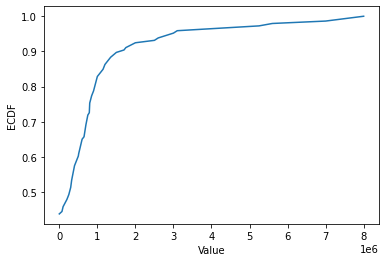

deferral_payments


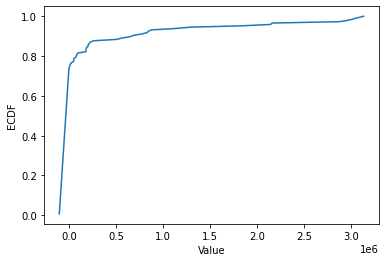

deferred_income


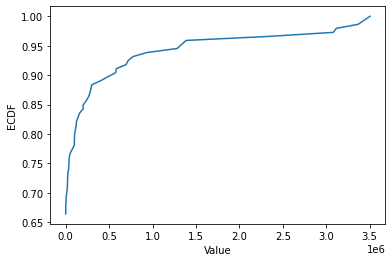

exercised_stock_options


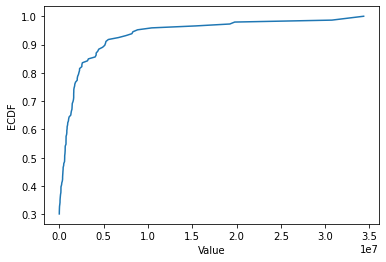

expenses


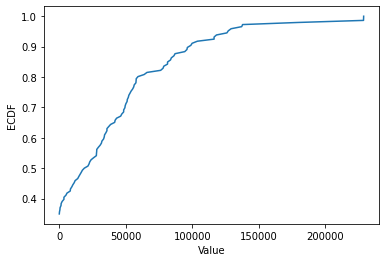

long_term_incentive


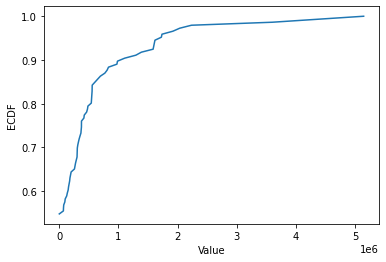

other


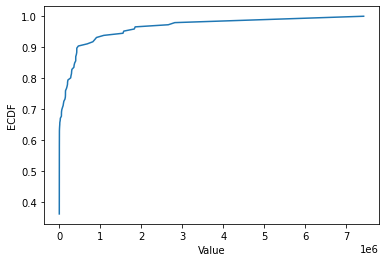

restricted_stock


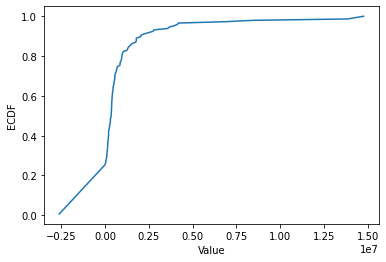

salary


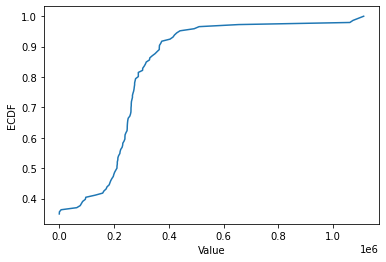

total_payments


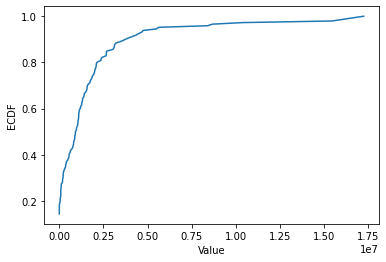

total_stock_value


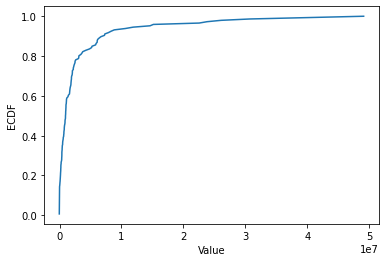

In [58]:
# 用'ECDF'檢視調整過後的df
for col in finanace_features:
    cdf = df[col].value_counts().sort_index().cumsum()
    plt.plot(list(cdf.index), cdf/cdf.max())
    plt.xlabel('Value')
    plt.ylabel('ECDF')
    print(col)
    plt.show()

In [59]:
outlier_count = pd.DataFrame()
for col in df_outlier.columns:
    outlier_count[col] = df_outlier.groupby(col).size()
outlier_count.index = [0,1]
print('outlier count：')
outlier_count.loc[1].T

outlier count：


bonus_outlier                      1
deferral_payments_outlier          2
deferred_income_outlier            1
exercised_stock_options_outlier    1
expenses_outlier                   1
long_term_incentive_outlier        1
other_outlier                      2
restricted_stock_outlier           1
salary_outlier                     1
total_payments_outlier             2
total_stock_value_outlier          1
Name: 1, dtype: int64

In [60]:
# 計算調整過後finanace_features 的z值
# Z值定義 ： 距離平均值z個標準差
df[finanace_features] = df[finanace_features].apply(lambda x :  (x - np.mean(x))/(np.std(x)))

In [61]:
df = pd.concat([df,df_outlier] , axis = 1)
df.shape

(146, 28)

# 資料前處理 （完）

In [62]:
# 將前述轉換完畢資料 df , 重新切成 X_train, X_test
train_num = y_train.shape[0]
X_train = df[:train_num]
X_test = df[train_num:]

In [63]:
# 把 X_train , y_train 切分 

X_train, X_val, y_train, y_val =  train_test_split(X_train , y_train , test_size = 0.3 , random_state = 7)

# DecisionTreeClassifier

In [91]:
dtclf = DecisionTreeClassifier(random_state = 40)
dtclf.fit(X_train , y_train)
y_pred = dtclf.predict(X_val)
print("acc_決策樹(未調整參數) :" , metrics.accuracy_score(y_pred, y_val))

acc_決策樹(未調整參數) : 0.8529411764705882


In [93]:
hyperparameter_space = {'max_depth':[2,3,4,6,8,10,12,15,20], 
                        'min_samples_leaf':[1,2,4,6,8,10,15,20],
                        'min_samples_split':[2,3,4,5,6,8,10]}

rs_dtclf = RandomizedSearchCV(dtclf, param_distributions=hyperparameter_space,
                        scoring="accuracy", random_state=40,
                        n_jobs=-1, cv=10, return_train_score=True)
rs_dtclf.fit(X_train , y_train)
rs_dtclf.best_params_

{'min_samples_split': 6, 'min_samples_leaf': 20, 'max_depth': 6}

In [94]:
best_dtclf = DecisionTreeClassifier(random_state = 40,
                              max_depth = rs_dtclf.best_params_['max_depth'],
                              min_samples_leaf = rs_dtclf.best_params_['min_samples_leaf'],
                              min_samples_split = rs_dtclf.best_params_['min_samples_split'])
best_dtclf.fit(X_train , y_train)
y_pred = best_dtclf.predict(X_val)
print("acc_決策樹(調整參數) :" , metrics.accuracy_score(y_pred, y_val))

acc_決策樹(調整參數) : 0.8823529411764706


In [95]:
best_dtclf.predict_proba(X_val)

array([[0.65, 0.35],
       [1.  , 0.  ],
       [0.9 , 0.1 ],
       [0.65, 0.35],
       [0.9 , 0.1 ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.65, 0.35],
       [0.9 , 0.1 ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.9 , 0.1 ],
       [0.65, 0.35],
       [1.  , 0.  ],
       [0.9 , 0.1 ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.65, 0.35],
       [0.9 , 0.1 ],
       [1.  , 0.  ],
       [0.65, 0.35],
       [0.65, 0.35],
       [0.65, 0.35],
       [0.65, 0.35],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.9 , 0.1 ],
       [0.9 , 0.1 ]])

# RandomForestClassifier

In [67]:
rfc = RandomForestClassifier(random_state = 40)
rfc.fit(X_train , y_train)
y_pred = rfc.predict(X_val)
print(f'acc_隨機森林(未調整參數){metrics.accuracy_score(y_pred, y_val)}')

acc_隨機森林(未調整參數)0.8823529411764706


In [68]:
hyperparameter_space = {'n_estimators':[100,200,300,400],
                        'max_depth':[2,3,4,6,8,10,12,15,20], 
                        'min_samples_leaf':[1,2,4,6,8,10,15,20],
                        'min_samples_split':[2,3,4,5,6,8,10]}
rs_rfc = RandomizedSearchCV(rfc, param_distributions=hyperparameter_space,
                        scoring="recall", random_state=40,
                        n_jobs=-1, cv=10)
rs_rfc.fit(X_train , y_train)
rs_rfc.best_params_

{'n_estimators': 300,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 12}

In [69]:
best_rfc = RandomForestClassifier(random_state = 40,
                              n_estimators = rs_rfc.best_params_['n_estimators'],
                              max_depth = rs_rfc.best_params_['max_depth'],
                              min_samples_leaf = rs_rfc.best_params_['min_samples_leaf'],
                              min_samples_split = rs_rfc.best_params_['min_samples_split'])
best_rfc.fit(X_train , y_train)
y_pred = best_rfc.predict(X_val)
print(f'acc_隨機森林(調整參數){metrics.accuracy_score(y_pred, y_val)}')

acc_隨機森林(調整參數)0.8823529411764706


# LogisticRegression

In [70]:
lr = LogisticRegression(random_state = 40)
lr.fit(X_train , y_train)
y_pred = lr.predict(X_val)
print(f'acc_LogisticRegression(未調整參數){metrics.accuracy_score(y_pred, y_val)}')

acc_LogisticRegression(未調整參數)0.8823529411764706


In [71]:
penalty = ['l1','l2'] # L1正則&L2正則
C = [0.01,0.1,1,10,100] # 平滑程度 Alpha ? 
param_grid = dict(penalty = penalty , C = C )
grid = GridSearchCV(lr , param_grid , scoring = 'accuracy' , n_jobs = -1 )
grid.fit(X_train , y_train)
grid.best_params_

{'C': 1, 'penalty': 'l1'}

In [72]:
best_lr = LogisticRegression(random_state = 40 ,
                        C = grid.best_params_['C'] ,
                        penalty = grid.best_params_['penalty'])
best_lr.fit(X_train , y_train)
y_pred = best_lr.predict(X_val)
print(f'acc_LogisticRegression(調整參數){metrics.accuracy_score(y_pred, y_val)}')

acc_LogisticRegression(調整參數)0.9117647058823529


# GDBT

In [73]:
gdbt = GradientBoostingClassifier(random_state = 40)
gdbt.fit(X_train , y_train)
y_pred = gdbt.predict(X_val)
print(f'acc_gbdt(未調整參數){metrics.accuracy_score(y_pred, y_val)}')

acc_gbdt(未調整參數)0.8823529411764706


In [74]:
n_estimators = [100,200,300,400,500]
max_depth = [3,5,7,10,15,20]
learning_rate = [0.1 , 0.3 ,0.5 , 0.7]
param_grid = dict(n_estimators = n_estimators , max_depth = max_depth , learning_rate = learning_rate )
grid = GridSearchCV(gdbt , param_grid , scoring = 'accuracy' , n_jobs = -1 )
grid.fit(X_train , y_train)
grid.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}

In [75]:
best_gdbt = GradientBoostingClassifier(random_state = 40 ,
                                  n_estimators = grid.best_params_['n_estimators'],
                                  max_depth = grid.best_params_['max_depth'],
                                  learning_rate = grid.best_params_['learning_rate'])
best_gdbt.fit(X_train , y_train)
y_pred = best_gdbt.predict(X_val)
print(f'acc_gbdt(調整參數){metrics.accuracy_score(y_pred, y_val)}')

acc_gbdt(調整參數)0.8823529411764706


    DecisionTreeClassifier
    RandomForestClassifier
    LogisticRegression
    GDBT

In [76]:
sample_submission.head()

,name,poi
0,BELDEN TIMOTHY N,0.007201
1,BOWEN JR RAYMOND M,0.903340
2,HANNON KEVIN P,0.572731
3,DELAINEY DAVID W,0.950927
4,CAUSEY RICHARD A,0.942402


In [117]:
dtclf_y_pred = best_dtclf.predict_proba(X_test)[:,1]
sub_dtclf = pd.DataFrame({'name':ids, 'poi':dtclf_y_pred})
sub_dtclf.to_csv('sub_dtclf_sub.csv' , index = False)

In [113]:
# score in test 0.77142
rfc_y_pred = best_rfc.predict_proba(X_test)[:,1]
sub_rfc = pd.DataFrame({'name':ids, 'poi':rfc_y_pred})
sub_rfc.to_csv('sub_rfc.csv' , index = False)

In [111]:
# score in test 0.71785
gdbt_y_pred = best_gdbt.predict_proba(X_test)[:,1]
sub_gdbt = pd.DataFrame({'name':ids, 'poi':gdbt_y_pred})
sub_gdbt.to_csv('sub_gdbt.csv' ,index = False)

In [110]:
# score in test 0.73571 
lr_y_pred = best_lr.predict_proba(X_test)[:,1]
sub_lr = pd.DataFrame({'name':ids, 'poi':lr_y_pred})
sub_lr.to_csv('sub_lr.csv' , index = False)

# blending

In [120]:
blending_pred = rfc_y_pred*0.4 + gdbt_y_pred*0.28 + lr_y_pred*0.32
sub_blending = pd.DataFrame({'name': ids, 'poi': blending_pred})
sub_blending.to_csv('poi_blending.csv', index=False)